In [30]:


import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline



In [31]:
from graphviz import Digraph
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [50]:
"""
This is my implementation of micrograd by the smart Machine Learning guy with the russian name
"""


import math


class Value:
    def __init__(self, data, _children = (), _op = '', label = ''):
        self.data =  data
        self.grad = 0
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self._backward = lambda: None

    def __repr__(self) -> str:
        return f"Value(data = {self.data})"
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward
        
        return out 
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward 

        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward

        return out
   
    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward() 


a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; label = 'd'
f = Value(-2.0, label='f')
L = d*f; L.label =  'L' 
print(L)


Value(data = -8.0)


In [48]:
x1 = Value (2.0, label = "x1")
x2 = Value (0.0, label = "x2")

w1 = Value(-3.0, label= "w1")
w2 = Value(1.0, label= "w2")

b = Value(6.8813735870195432); b.label = "b"
x1w1 = x1*w1; x1w1.label = "x1*w1"
x2w2 = x2*w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2w2"
n = x1w1x2w2 + b; n.label = "n"
o = n.tanh(); o.label = "o"



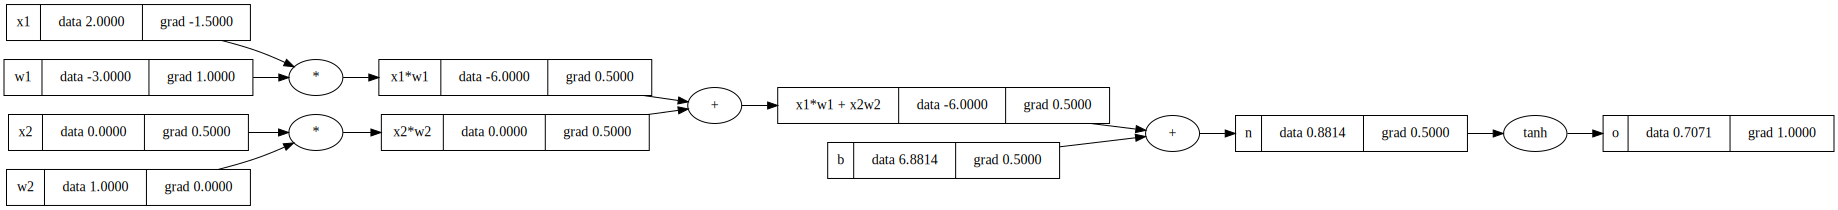

In [49]:
o.backward()
draw_dot(o)